In [1]:
import math
import pickle
import copy
import gzip
import pandas as pd
import numpy as np
import random
from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
from matplotlib import pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from scipy.stats import maxwell

In [2]:
# Fucntion that prints the structure based on it's initial_structure
def printStructure(d, string):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
    ax.set_title(f'{string}')

In [3]:
#Function, that sets the first defect
def SettingFirstDefect(numOfDef, pos):
    l = []
    while True:
        if numOfDef == 0:
            break
        
        if pos == 1:
            x = np.random.randint(64, 128)
        if pos == 2:
            x = np.random.randint(0, 64)
        if pos == 3:
            x = np.random.randint(128, 192)
        if x in l:
            continue
        else:
            l.append(x)
            numOfDef -= 1
    return l

In [4]:
 # Counts Defect Interaction Energy based on the distance between two defects
def Defect_Interaction_Energy(x):
#     print("Расстояние = ", x)
    # formula for interaction between Mo and S
#     E = (((x * (math.cos(0.5) * ((math.cos(((0.5 * (4 * (x * (4 - x)))) / x)) * x) / x))) - x) / ((math.exp(x)) / x))
    
    # formula for interaction between S and S in one layer 
    E = math.cos(1-x) / math.exp(x)
    
    # formula for interaction between S and S in different layers
#     E = math.cos(5 - x) / ((2**x) + 1 + x)
    
    
#     print("Результат = ", E)
    return E

In [15]:
#Function, that detects the probability of jump and return 1 or 0
def RandJump(energy_of_barrier, loc, scale):
    prob = 1 - maxwell.cdf(energy_of_barrier, loc, scale)
    
#     print("Вероятность скачка: ", prob)
#     print (random.choices([0, 1], [1 - prob, prob]))
    
    return(random.choices([0, 1], [1 - prob, prob])[0])
#     return(random.choices([0, 1], [1 - 0.5, 0.5])[0])

In [6]:
def energy_of_barrier_calc(x, e, m):
    if x < 0:
            energy_of_barrier = 0.1
    else:
        energy_of_barrier = math.sqrt(2 * x * e * m)
    return energy_of_barrier

In [7]:
#Main Rand fucntion which uses funcs RandJump and Defect_Interaction_Energy
#This function equiprobably chooses where defect will go
#and then with RandJump chooses whether the event happens
#connection - словарь с ключом - рассматриваевым дефектом и значениями -
#другими дефектами, которые влияют на данный дефект
def Rand(connection):
    a = np.random.randint(0, 7)
    
    E_pot = 0.94
    e = 1.60217663 * 10 ** (-19)
    m_electon = 9.1093837 * 10 ** (-34)
    m_mol = 1.5932871 * 10 ** (-22)
    m_sulf =  1.088 * 10 ** (-20)
    k = 1.380649 * 10 ** (-23)
    T = 700
    
    m = m_sulf
    
    loc = math.sqrt(2 * m * k * T)
    
    scale = math.sqrt(m * k * T)
    energy_of_interaction = 0

    
    
    x1 = list(connection.keys())[0].coords[0]
    y1 = list(connection.keys())[0].coords[1]
    x = list()
    y = list()
    for i in list(connection.values())[0]:
        x.append(i.coords[0])
        y.append(i.coords[1])
    rast = list()
        
    if a == 0:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2)) # must be corrected
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)  # It is initially an momentum to jump through the barrier
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])
            
            
    elif a == 1:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 2:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 3:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 + 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 4:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 2 * 1.5952 / 2 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
            
    elif a == 5:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 / 2 - x[i]) ** 2 + (y1 - 2.7629 / 2 - y[i]) ** 2))
            
        energy_of_barrier = energy_of_barrier_calc(E_pot + energy_of_interaction, e, m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 6:
        res = np.array([0, 0, 0])
        energy_of_barrier = math.sqrt(2 * E_pot * e * m)
        
        
#     print('loc = ', loc, 'energy_of_barrier = ', energy_of_barrier, 'scale = ', scale)

#     print("Барьер: ", E_pot + energy_of_interaction, '\n')
    return res

In [8]:
# Creating new structure with one defect based in function Rand() and old structure
def newDefects(olddata, numOfDef):

    
    newdata = pd.read_pickle('emptydata.pkl')
    newdata = newdata.iloc[0]
    newdata.defect_representation.clear()
    
    DefWithNoChanges = 0
    for i in range(len(list(olddata.defect_representation))):
        while True:
            connection = dict()
            connection = {olddata.defect_representation[i] : olddata.defect_representation[:i] + olddata.defect_representation[i+1:]}
#             print(connection)
            newPositionCoords = Rand(connection)
            newcoord = (olddata.defect_representation[i].coords + newPositionCoords)
            if (newcoord[0] + (newcoord[1] / 1.732) < 25) and (newcoord[0] + newcoord[1] / 1.732 > 2) and (-10 < newcoord[0] < 24) and (0 < newcoord[1] < 21):
                break
        ###
        if np.array_equal(newPositionCoords, np.array([0,0,0])):
            DefWithNoChanges += 1
        ###
        index = np.where((np.round(olddata.initial_structure.cart_coords[:,0], 1) 
                     == np.round(newcoord[0], 1))
                    & (np.round(olddata.initial_structure.cart_coords[:,1], 1) 
                     == np.round(newcoord[1], 1)) &
                        (np.round(olddata.initial_structure.cart_coords[:,2], 1) 
                     == np.round(newcoord[2], 1)))
        index = index[0][0]
        newdata.initial_structure.replace(index, Element('Se'))
        newdata.defect_representation.append(newdata.initial_structure[index].species, newdata.initial_structure[index].frac_coords)

    if DefWithNoChanges == numOfDef:
        return False
    return newdata

In [9]:
#You can choose the number of defects
numOfDef = 5

In [10]:
#Reading the structure with no defects 
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

In [11]:
# Setting Randomly first defect
pos = 3 # pos = 1 - lower sulfide. pos = 2 - molybdenum. pos = 3 - upper sulfide
l = SettingFirstDefect(numOfDef, pos)
for i in range(len(l)):
    dataBegin.initial_structure.replace(l[i], Element('Se'))
    dataBegin.defect_representation.append(dataBegin.initial_structure[l[i]].species, dataBegin.initial_structure[l[i]].frac_coords)

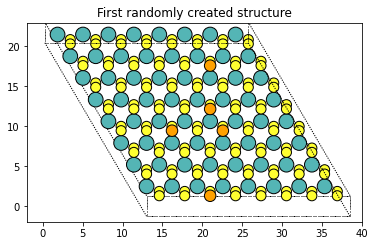

In [12]:
string = "First randomly created structure"
printStructure(dataBegin, string)

In [13]:
#Код, который помогает определить на какой итерации происходят скачки для построения диаграммы скачков
listofchanges = []

In [22]:
#Код, который помогает определить на какой итерации происходят скачки для построения диаграммы скачков
for i in range(100):
    # Creating a list of structures with defects
    datamain = pd.DataFrame()
    datamain = datamain.append(dataBegin)
    olddata = dataBegin.copy()
    string = "First structure"
#     printStructure(olddata, string)
    k = 0
    for i in range(500):    
        newdata = newDefects(olddata, numOfDef)
        ### doesn't print with no new position
        if type(newdata) != bool:
            k += 1
            datamain = datamain.append(newdata)
            olddata = newdata
            string = f"The number of iteration: {k}"
            listofchanges.append(k)
    #         printStructure(newdata, string)
        else:
            k += 1


    print(listofchanges)

        ###

    #     datamain = datamain.append(newdata)
    #     olddata = newdata
    #     printStructure(newdata)

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

[302, 28, 217, 86, 413, 482, 485, 245, 271, 340, 310, 94, 120, 5, 243, 266, 183, 321, 42, 253, 49, 498, 53, 205, 3, 370, 410, 454, 410, 227, 96, 109, 143, 325, 403, 250, 56, 105, 147, 129, 151, 294, 390, 255, 127, 181, 422, 266, 297, 368, 438, 259, 298, 486, 143, 339, 10, 57, 90, 444, 92, 469, 125, 137, 315, 252, 107, 440, 159, 222, 393, 225, 336, 356, 448, 16, 146, 47, 363, 212, 457, 330, 207, 253, 353, 478, 97, 146, 160, 352, 492, 179, 107, 170, 20, 7, 353, 257, 430, 463, 31, 217, 142, 220, 293, 22, 443, 176, 2, 27, 371, 440, 494, 470, 122, 280, 57, 145, 233, 431, 336, 31, 257, 309, 345, 328, 338, 43, 45, 360, 36, 254, 341, 160, 83, 464, 490, 28, 69, 302, 481, 480, 293, 95, 306, 354, 438, 229, 366, 283, 43, 134, 181, 326, 475, 60, 251, 97, 155, 317, 343, 1, 248, 342, 364, 33, 70, 205, 33, 147, 470, 358, 245, 106, 307, 375, 500, 160, 373, 404, 470, 135, 477, 477, 20, 434, 355, 9, 37, 297, 474, 28, 258, 315, 410, 392, 277, 402, 377, 421, 232, 275, 190, 163, 317, 421, 432, 65, 17, 62, 3

<function matplotlib.pyplot.show(close=None, block=None)>

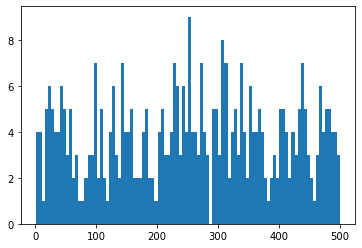

In [24]:
#Построение диаграммы скачков
import matplotlib.pyplot as plt

plt.hist(listofchanges, bins= 100)
plt.show

There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no 

There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no changes
There are no 

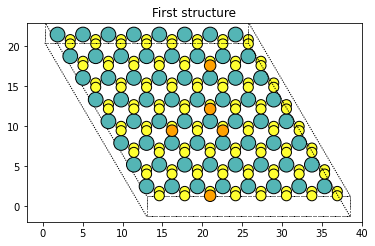

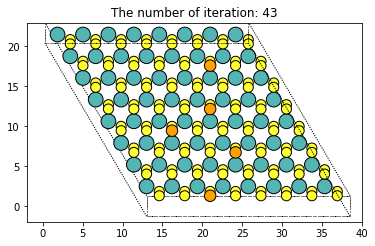

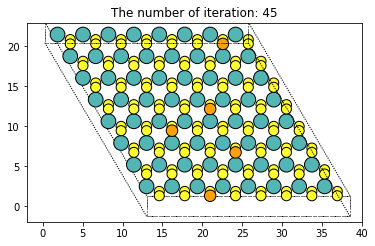

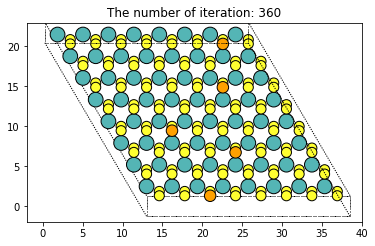

In [18]:
for j in range(1):
    # Creating a list of structures with defects
    datamain = pd.DataFrame()
    datamain = datamain.append(dataBegin)
    olddata = dataBegin.copy()
    string = "First structure"
    printStructure(olddata, string)
    k = 0
    for i in range(500):    
        newdata = newDefects(olddata, numOfDef)
        if type(newdata) != bool:
            k += 1
            datamain = datamain.append(newdata)
            olddata = newdata
            string = f"The number of iteration: {k}"
            listofchanges.append(k)
            printStructure(newdata, string)
        else:
            k += 1
            print("There are no changes")